Библиотеки для иллюстраций (запуск рендера иллюстраций на локальной машине):

In [41]:
from IPython import display
from base64 import b64decode

In [76]:
from images import *

# Прототип алгоритма «Solution Existence Detection» (часть 1, теория)

Алгоритм определения наличия решений (хотя бы одной «хорошей» комбинации). Применим в тех ситуациях, когда нет необходимости точно знать число решений, а достаточно определить, есть ли решения вообще или нет. Требует дополнительных кубитов, сложность зависит от необходимой точности.

Библиотеки и утилиты:

In [43]:
import numpy as np
import plotly.graph_objects as go

def show(data, title="Picture", marker_size=3):
    fig = go.Figure()

    for g in data:

        xy = g[0]
        color = g[1]
        opacity = 1
        if len(g) == 3:
            opacity = g[2]

        fig.add_trace(go.Scatter(
            x=[i[0] for i in xy],
            y=[i[1] for i in xy],
            mode='markers',
            marker_color=color,
            opacity=opacity
        ))

    fig.update_traces(mode='markers', marker_size=marker_size)
    fig.update_layout(title=title, yaxis_zeroline=False, xaxis_zeroline=False)

    fig.show()

## Теория

Алгоритм измерения фазы Китаева:

$$
P_{(0)} = \frac{1 + \cos{\theta}}{2}
$$
где $\theta$ — фаза оператора.

Схема алгоритма:

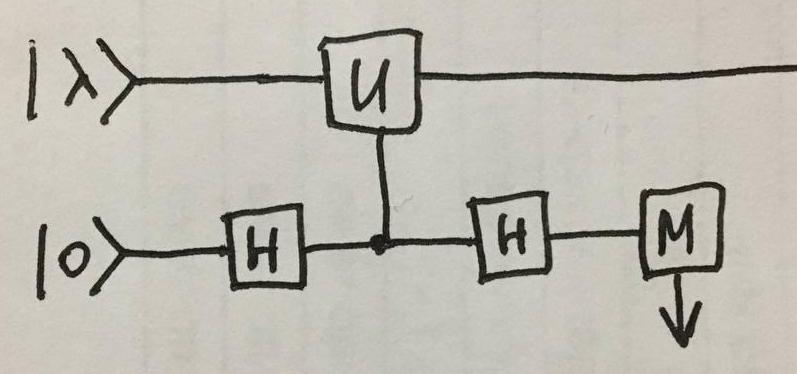

In [44]:
display.Image(b64decode(scheme_kitaev))

Квантовый алгоритм усиления амплитуды действуя на схему изменяет фазу на $(2j \cdot \theta_a)$, где:

- $\theta_a$ — угол, соответствующий числу «хороших» комбинаций и связан с этим числом формулой:

$$
\theta_a = \arcsin{ \left( \sqrt{\tfrac{n}{N}} \right)}
$$

- $j$ — число итераций в алгоритме;
- $n$ — число «хороших» комбинаций;
- $N$ - общее число возможных комбинаций в состоянии суперпозиции, равное $2^q$;
- $q$ — число кубит, находящихся в суперпозиции и подаваемых на вход в оракул (такой расчет числа возможных комбинаций справедлив для алгоритма Гровера).

Совместим:

$$
\theta = 2j \cdot \theta_a \\
P_{(0)} = \frac{1 + \cos{ \left( 2j \cdot \theta_a \right) }}{2} =  \frac{1 + \cos{ \left( 2j \cdot \arcsin{\left(\sqrt{\tfrac{n}{N}} \right)} \right) }}{2}
$$

Представим в виде функции:

In [45]:
def get_P_of_0(j, n, N):
    return (1+np.cos(2*j*np.arcsin(np.sqrt(n/N))))/2

Рассмотрим ситуацию $j = 1$.

Тогда:
- при $\theta = 0$: $P_{(0)} = 1$;
- когда $n = N$ и $\theta = \frac{\pi}{2}$: $P_{(0)} = 0$.

Будем работать со следующей схемой:

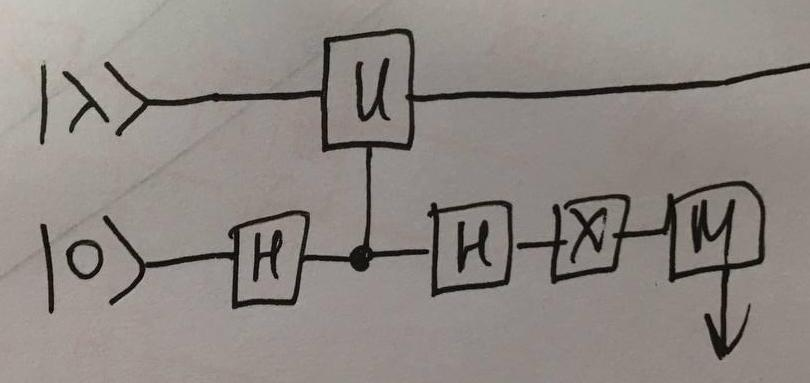

In [46]:
display.Image(b64decode(scheme_kitaev_2))

Тогда:
- при $\theta = 0$: $P_{(0)} = 0$;
- когда $n = N$ и $\theta = \frac{\pi}{2}$: $P_{(0)} = 1$.

Построим график зависимости $P_{(0)}$ от числа «хороших» комбинаций $n$ при условии, что число итераций $j = 1$:

In [47]:
q = 10

N = 2 ** q

j = 1

R = []
for n in [0, 1, *list(range(1, N, 1)), N]:
    p = 1 - get_P_of_0(j, n, N)
    R.append((n, p))

show([[[(x[0], x[1]) for x in R], 'blue', 1]], marker_size=2)

Для $j = 2$:

In [48]:
j = 2

R = []
for n in [0, 1, *list(range(1, N, 1)), N]:
    p = 1 - get_P_of_0(j, n, N)
    R.append((n, p))

show([[[(x[0], x[1]) for x in R], 'blue', 1]], marker_size=2)

Для $j = 5$:

In [49]:
j = 5

R = []
for n in [0, 1, *list(range(1, N, 1)), N]:
    p = 1 - get_P_of_0(j, n, N)
    R.append((n, p))

show([[[(x[0], x[1]) for x in R], 'blue', 1]], marker_size=2)

На графике каждый холм будем обозначать номером $k$.

Последний холм является полухолмом для нечетных $j$, и полноценным холмом — для четных.

Введем дополнительно понятия:
- **upwards** (u) — на подъеме холма;
- **downwards** (d) — на спуске холма.

### Основные формулы

Найти такое число итераций $j$, при котором на подъеме определенного холма при заданном числе решений $n$ вероятность будет $P_{(0)}$:

$$
j_{u} = \frac{2 \pi (k - 1) + \arccos{\left(2P_{(0)} - 1\right)}}{2 \cdot \arcsin{\sqrt{\tfrac{n}{N}}}}
$$

То же, но на спуске холма:

$$
j_{d} = \frac{2 \pi k - \arccos{\left(2P_{(0)} - 1\right)}}{2 \cdot \arcsin{\sqrt{\tfrac{n}{N}}}}
$$

In [50]:
def get_j(k, dir, P_of_0, n, N):
    if dir == 'up':
        return (2*np.pi*(k-1)+np.arccos(2*P_of_0-1))/(2*np.arcsin(np.sqrt(n/N)))
    elif dir == 'down':
        return (2*np.pi*k-np.arccos(2*P_of_0-1))/(2*np.arcsin(np.sqrt(n/N)))

Найти такое число $n$, при котором на подъеме определенного холма при заданном числе итераций $j$ вероятность будет $P_{(0)}$:

$$
n_{u} = \sin^2 {\left( \frac{2 \pi (k - 1) + \arccos{\left(2P_{(0)} - 1\right)}}{2j} \right)}
$$

$$
n_{d} = \sin^2 {\left( \frac{2 \pi  k - \arccos{\left(2P_{(0)} - 1\right)}}{2j} \right)}
$$

In [51]:
def get_n(k, dir, j, P_of_0, N):
    if dir == 'up':
        return N*np.sin((2*np.pi*(k-1)+np.arccos(2*P_of_0-1))/(2*j))**2
    elif dir == 'down':
        return N*np.sin((2*np.pi*k-np.arccos(2*P_of_0-1))/(2*j))**2

Теперь в схему добавим еще нескольку контроллирующих кубит и один результирующий, в который будем складывать логическое «И» всех инвертированных контроллирующих кубитов:

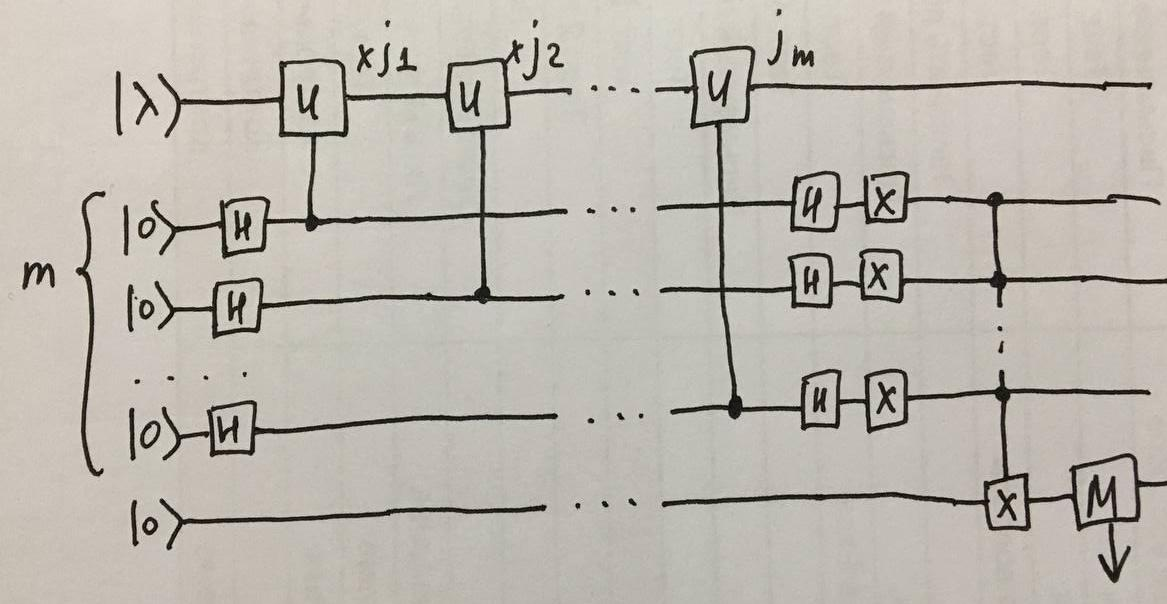

In [52]:
display.Image(b64decode(scheme_SED))

Вероятность $P_{(0)}$ для результирующего кубита в таком случае определяется формулой:

$$
P_{(0)}(n) = \frac{1 + \cos{ \left( 2j_1 \cdot \arcsin{\left(\sqrt{\frac{n}{N}}\right)} \right) }}{2} \times \frac{1 + \cos{ \left( 2j_2 \cdot \arcsin{\left(\sqrt{\frac{n}{N}}\right)} \right) }}{2} \times \cdots
$$

Представим в виде функции:

In [53]:
def get_P_of_0_complex(js, n, N):
    return 1 - np.prod([get_P_of_0(j, n, N) for j in js])

## Пример расчета

Представим, что у нас есть некоторая задача, в рамках которой мы используем $q$ кубит, переведенных в состояние суперпозиции. Тогда общее число комбинаций будет $N = 2 ^q$. Положим для примера $q = 10$ и соответственно $N = 2^{10} = 1024$.

In [54]:
q = 10
N = 2 ** q
N

1024

Зададим минимальную вероятность $P_{min}$ — это нижняя граница вероятности $P_{(0)}, ниже которой мы с некоторой долей вероятности (рассчитать) можем утверждать, что решений нет. Выше — есть.

In [55]:
P_min = 0.2

Число итераций, необходимое для того, чтобы при единственном решении его вероятность появления была равна $P_{min}$:

In [56]:
j_P_min = (1/2)*(np.arcsin(np.sqrt(P_min))/np.arcsin(np.sqrt(1/N))-1)
j_P_min = int(np.ceil(j_P_min))
j_P_min

7

Число итераций, необходимое для того, чтобы при единственном решении его вероятность появления была близка к 1:


In [57]:
j_P_is_1 = (1/2)*(np.arcsin(np.sqrt(1))/np.arcsin(np.sqrt(1/N))-1)
j_P_is_1 = int(np.ceil(j_P_is_1))
j_P_is_1

25

Для того, чтобы вероятность одного решения была точно больше $P_{min}$ необходимо **j_P_min** итераций, а чтобы 1 решение имело вероятность близкую к 1, необходимо **j_P_is_1** итераций.

### Число итераций в алгоритме SED

In [58]:
j_1 = get_j(k=1, dir='up', P_of_0=1-P_min, N=N, n=1)
j_1

14.834307988227103

Округляем в большую сторону:

In [59]:
j_1 = int(np.ceil(j_1))
j_1

15

In [60]:
C = []

for n in [0, 1, *list(range(1, N, 1)), N]:
    p = get_P_of_0_complex([j_1], n, N)
    C.append((n, p))

p_1 = get_P_of_0_complex([j_1], n=1, N = N)
print(p_1)

show([[[(x[0], x[1]) for x in C], 'blue', 0.5]])

0.20415899205099786


При каком числе решений на спуске с первого холма вероятность будет равна $P_{min}$:

In [61]:
n_1 = get_n(k=1, dir='down', j=j_1, P_of_0 = 1-P_min, N=N)
n_1

32.292508358800866

Округляем в меньшую сторону:

In [62]:
n_1 = int(np.floor(n_1))
n_1

32

При каком числе итераций мы получим функцию, на подъеме первого холма которой число решений, полученных выше, будет равно $P_{min}$:

In [63]:
j_2 = get_j(k=1, dir='up', P_of_0 = 1-P_min, N=N, n=n_1)
j_2

2.6090036654870694

Округляем в большую сторону:

In [64]:
j_2 = int(np.ceil(j_2))
j_2

3

Мы получили первый варимант комбинации двух функции, построим график:

In [65]:
js = [j_1, j_2]

rlts = []

for j in js:

    C = []
    for n in [0, 1, *list(range(1, N, 1)), N]:
        p = get_P_of_0_complex([j], n, N)
        C.append((n, p))

    rlts.append(C)

C = []

for n in [0, 1, *list(range(1, N, 1)), N]:
    p = get_P_of_0_complex(js, n, N)
    C.append((n, p))

rlts.append(C)

datasets = [[[(x[0], x[1]) for x in C], 'blue', 0.5] for C in rlts]
datasets[-1][1] = 'red'
datasets[-1][2] = 1

show(datasets, marker_size=2)

При каком числе решений на спуске с первого холма второй функции вероятность будет стремиться сверху к $P_{min}$:

In [66]:
n_3 = get_n(k=1, dir='down', j=j_2, P_of_0 = 1-P_min, N = N)
n_3

620.9839485866287

Округляем в меньшую сторону:

In [67]:
n_3 = int(np.floor(n_3))
n_3

620

При каком числе итераций мы получим функцию, на подъеме первого холма которой число решений 620 будет иметь вероятность $P_{min}$:

In [68]:
j_3 = get_j(k=1, dir='up', P_of_0=1-P_min, N=N, n=n_3)
j_3

0.5199795209320706

Округляем в большую сторону:

In [69]:
j_3 = int(np.ceil(j_3))
j_3

1

Достигнут предел $j = 1$.

Итого схема получилась следующей:

In [70]:
scheme = [j_1,j_2,j_3]
scheme

[15, 3, 1]

Число итераций:

In [71]:
sum(scheme)

19

Число кубит:

In [72]:
len(scheme) + 1

4

Построим график со всеми составляющими функциями:

In [73]:
rlts = []

for j in scheme:

    C = []
    for n in [0, 1, *list(range(1, N, 1)), N]:
        p = get_P_of_0_complex([j], n, N)
        C.append((n, p))

    rlts.append(C)

C = []

for n in [0, 1, *list(range(1, N, 1)), N]:
    p = get_P_of_0_complex(scheme, n, N)
    C.append((n, p))

rlts.append(C)

datasets = [[[(x[0], x[1]) for x in C], 'blue', 0.5] for C in rlts]
datasets[-1][1] = 'red'
datasets[-1][2] = 1

show(datasets, marker_size=2)

Из графика видно, что ни при каком числе «хороших» комбинаций $n$ вероятность $P_{(0)}$ не будет опускаться ниже $P_{min}$, кроме ситуации, когда решений нет совсем $n = 0$.

## Функция для расчета схемы алгоритма

In [74]:
def get_SED_scheme(P_min, N):
    def get_j(k, dir, P_of_0, n, N):
        if dir == 'up':
            return (2*np.pi*(k-1)+np.arccos(2*P_of_0-1))/(2*np.arcsin(np.sqrt(n/N)))
        elif dir == 'down':
            return (2*np.pi*k-np.arccos(2*P_of_0-1))/(2*np.arcsin(np.sqrt(n/N)))
    def get_n(k, dir, j, P_of_0, N):
        if dir == 'up':
            return N*np.sin((2*np.pi*(k-1)+np.arccos(2*P_of_0-1))/(2*j))**2
        elif dir == 'down':
            return N*np.sin((2*np.pi*k-np.arccos(2*P_of_0-1))/(2*j))**2
    js = []
    n = 1
    while True:
        j = int(np.ceil(get_j(k=1, dir='up', P_of_0=1-P_min, N=N, n=n)))
        js.append(j)
        if j == 1:
            break
        n = int(np.floor(get_n(k=1, dir='down', j=j, P_of_0=1-P_min, N=N)))
    return js

In [75]:
scheme = get_SED_scheme(P_min=P_min, N=N)
scheme

[15, 3, 1]

В следующей части мы опробуем алгоритм на тестовом примере.